This script offers a preliminary evaluation of a variant of the motif graph learning algorithm that considers the observations follow a GMRF whose precision matrix is given by a polynomial of the GSO.

In [1]:
import cvxpy as cp
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

import time
from joblib import Parallel, delayed
from os import cpu_count

from sklearn.covariance import graphical_lasso
import src.utils as utils
import spectral_nti as snti

SEED = 0
N_CPUS = cpu_count()
np.random.seed(SEED)

PATH = './results/gmrf_st/'

## Auxiliary functions

In [2]:
def est_graph(id, models, MM, L, K, iters, verb=False):
    X = utils.create_GMRF_st_signals(L, K, MM[-1])

    N = X.shape[0]
    A_hat = np.zeros((N, N, len(models), len(MM)))
    lamd_hat = np.zeros((N, len(models), len(MM)))
    for i, M in enumerate(MM):
        C_hat = X[:,:M]@X[:,:M].T/M

        # Individual standard constraints
        for j, model in enumerate(models):
            t = time.time()

            if model['name'] == 'GLasso':
                try:
                    _, L_hat = graphical_lasso(C_hat, model['alpha'], max_iter=iters)
                except FloatingPointError:
                    L_hat = np.zeros((N,N))
            elif model['St']:
                L_hat, _ = snti.MGL_Stationary_GMRF(C_hat, model['gs'], model['bounds'], 
                                                    model['cs'], model['regs'], max_iters=iters,
                                                    verbose=verb, epsilon=1e-5)
            else:
                L_hat, _ = snti.MGL(C_hat, model['gs'], model['bounds'], 
                                    model['cs'], model['regs'], max_iters=iters,
                                    verbose=verb, epsilon=1e-5)

            lamd_hat[:,j,i], _ = np.linalg.eigh(L_hat) 
            A_hat[:,:,j,i] = np.diag(np.diag(L_hat)) - L_hat
            t = time.time() - t
            print('Cov-{}, M-{}: Model: {}-{} - Time(sec): {:.3}'.format(id, M, model['name'],  model['St'], t))
    return A_hat, lamd_hat


def est_errs(A, lamd, A_hat, lams_hat, sq_err=True):
    norm_A = np.linalg.norm(A, 'fro')
    norm_lam = np.linalg.norm(lamd, 2)

    err_lamb = np.zeros(lams_hat.shape[1:])
    err_A = np.zeros(A_hat.shape[2:])
    for k in range(A_hat.shape[-1]):
        for i in range(A_hat.shape[-2]):
            for j in range(A_hat.shape[-3]):
                if np.all((A_hat[:,:,j,i,k] == 0)):
                    norm_A_hat = 1
                    norm_lam_hat = 1
                else:
                    norm_A_hat = np.linalg.norm(A_hat[:,:,j,i,k], 'fro')
                    norm_lam_hat = np.linalg.norm(lams_hat[:,j,i,k], 2)

                A_hat_norm = A_hat[:,:,j,i,k]/norm_A_hat
                lam_hat_norm = lams_hat[:,j,i,k]/norm_lam_hat
                err_A[j,i,k] = np.linalg.norm(A/norm_A-A_hat_norm,'fro')
                err_lamb[j,i,k] = np.linalg.norm(lamd/norm_lam-lam_hat_norm, 2)

                if sq_err:
                    err_A[j,i,k] = err_A[j,i,k]**2
                    err_lamb[j,i,k] = err_lamb[j,i,k]**2

    return err_A, err_lamb


def est_errs2(A, lamd, A_hat, lams_hat, sq_err=True):
    norm_A = np.linalg.norm(A, 'fro')
    norm_lam = np.linalg.norm(lamd, 2)

    err_lamb = np.zeros(lams_hat.shape[1:])
    err_A = np.zeros(A_hat.shape[2:])
    for k in range(A_hat.shape[-1]):
        for i in range(A_hat.shape[-2]):
            for j in range(A_hat.shape[-3]):

                err_A[j,i,k] = np.linalg.norm(A-A_hat[:,:,j,i,k],'fro')/norm_A
                err_lamb[j,i,k] = np.linalg.norm(lamd/-lams_hat[:,j,i,k], 2)/norm_lam

                if sq_err:
                    err_A[j,i,k] = err_A[j,i,k]**2
                    err_lamb[j,i,k] = err_lamb[j,i,k]**2

    return err_A, err_lamb


def plot_err(MM, models, err, ylab, semlogy=True, ylim=[]):
    plt.figure()
    for i, model in enumerate(models):
        if semlogy:
            plt.semilogy(MM, err[i,:], model['fmt'], label=model['name'],
                        linewidth=2, markersize=12)
        else:
            plt.plot(MM, err[i,:], model['fmt'], label=model['name'],
                     linewidth=2, markersize=12)
        plt.grid(True)
        plt.xlabel('Number of samples')
        plt.ylabel(ylab)
        plt.legend()
        plt.xlim([MM[0], MM[-1]])
        if ylim:
            plt.ylim(ylim)
        plt.tight_layout()


def print_err(MM, models, err):
    mean_err = np.mean(err, 2)
    std = np.std(err, 2)
    for i, M in enumerate(MM):
        print('M:', M)
        for j, model in enumerate(models):
            print('\t{}: mean err: {:.6f} - std: {:.6f}'.
                   format(model['name'], mean_err[j,i], std[j,i]))

## Create graphs

Norm of A: 11.224972160321824
Norm of lambdas: 31.080540535840104


Text(0.5, 1.0, 'True Lambdas, N: 20')

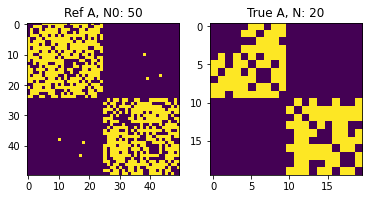

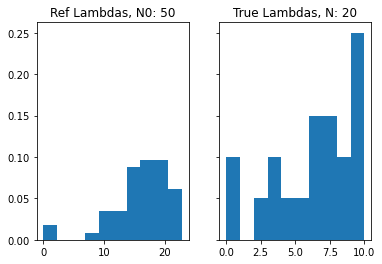

In [3]:
# G params
p = .7
q = .01
block_sizes0 = [25, 25]
block_sizes = [10, 10]

# Ref graph
A0 = nx.to_numpy_array(nx.random_partition_graph(block_sizes0, p, q))
L0 = np.diag(np.sum(A0, 0)) - A0
lambdas0, _ = np.linalg.eigh(L0)
N0 = lambdas0.shape[0]

# Target graph

A = nx.to_numpy_array(nx.random_partition_graph(block_sizes, p, q))
L = np.diag(np.sum(A, 0)) - A
lambdas, V = np.linalg.eigh(L)
N = lambdas.shape[0]

norm_A = np.linalg.norm(A,'fro')
norm_lamb = np.linalg.norm(lambdas)

print('Norm of A:', norm_A)
print('Norm of lambdas:', norm_lamb)

# Plot graphs and spectrum distribution
plt.figure()
plt.subplot(1,2,1)
plt.imshow(A0)
plt.title('Ref A, N0: ' + str(N0))
plt.subplot(1,2,2)
plt.imshow(A)
plt.title('True A, N: ' + str(N))
    
figs, axs = plt.subplots(1, 2, sharey=True)
axs[0].hist(lambdas0, density=True)
axs[0].set_title('Ref Lambdas, N0: ' + str(N0))
axs[1].hist(lambdas, density=True)
axs[1].set_title('True Lambdas, N: ' + str(N))

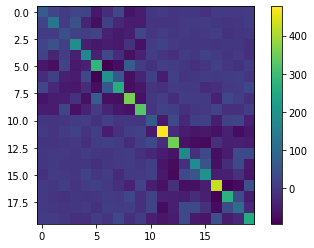

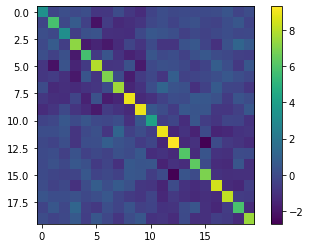

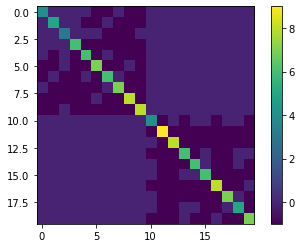

In [4]:
M = 300
K = 4
X = utils.create_GMRF_st_signals(L, K, M)
C_st = X[:,:M]@X[:,:M].T/M

X = utils.create_signals(L, M)
C = X[:,:M]@X[:,:M].T/M

plt.figure()
plt.imshow(np.linalg.pinv(C_st))
plt.colorbar()

plt.figure()
plt.imshow(np.linalg.pinv(C))
plt.colorbar()

plt.figure()
plt.imshow(L)
plt.colorbar()

## Compare contraints

In [5]:
n_covs = 10  #100
#MM = np.arange(300, 1501, 100)
MM = [100, 200, 300]
K = 4
iters = 30 # 50

GS = [
    lambda a, b : cp.sum(a)/b,
    lambda a, b : cp.sum(a**2)/b,
    lambda a, b : cp.sum(cp.exp(-a))/b,
    lambda a, b : cp.sum(cp.sqrt(a))/b,
    lambda a, b : cp.sum((.5*a-.75)**2)/b,
]
BOUNDS = [
    lambda lamd, lamd_t, b : -2/b*lamd_t.T@lamd,
    lambda lamd, lamd_t, b : 1/b*cp.exp(-lamd_t).T@lamd,
    lambda lamd, lamd_t, b : cp.sum(lamd/cp.sqrt(lamd_t))/(2*b),
    lambda lamd, lamd_t, b: 1/b*(0.75-.5*lamd_t).T@lamd,
]

# deltas = [.04, .27, .003, .02, 0.05]
deltas = [11, 257, .07, 1.9, 56]
cs, err_cs = utils.compute_cs(GS, lambdas0, lambdas, verbose=True)

models = [
    {'St': False, 'name': 'GLasso', 'alpha': 0.05, 'fmt': '^:'},

    
    {'St': True, 'name': 'Unc', 'gs': [], 'bounds': [], 'cs': [], 'fmt': '1-',
     'regs': {'alpha': .01, 'beta': 1.75, 'gamma': 0, 'eta': 1, 'inc_eta': 1.1,
               'deltas': []}},
   
    {'St': True, 'name': 'Tr', 'gs': GS[0], 'bounds': [], 'cs': cs[0], 'fmt': '2-',
     'regs': {'alpha': 0, 'beta': 1, 'gamma': 1, 'eta': 1, 'inc_eta': 1.1,
              'deltas': deltas[0]}},

    {'St': True, 'name': 'Sq', 'gs': GS[1], 'bounds': BOUNDS[0], 'cs': cs[1], 'fmt': 'o-',
     'regs': {'alpha': .0, 'beta': 1.25, 'gamma': 500, 'eta': .05, 'inc_eta': 1.1,
              'deltas': deltas[1]}},

    {'St': True, 'name': 'BR', 'gs': GS[4], 'bounds': BOUNDS[3], 'cs': cs[4], 'fmt': 's-',
     'regs': {'alpha': 0, 'beta': 1, 'gamma': 10, 'eta': .1, 'inc_eta': 1.1, 
              'deltas': deltas[4]}},

    # Non-st
    {'St': False, 'name': 'Unc', 'gs': [], 'bounds': [], 'cs': [], 'fmt': '1--',
     'regs': {'alpha': .01, 'beta': 1.75, 'gamma': 0,'deltas': []}},

    {'St': False, 'name': 'Tr', 'gs': GS[0], 'bounds': [], 'cs': cs[0], 'fmt': '2--',
     'regs': {'alpha': 0, 'beta': 1, 'gamma': 1, 'deltas': deltas[0]}},

    {'St': False, 'name': 'Sq', 'gs': GS[1], 'bounds': BOUNDS[0], 'cs': cs[1], 'fmt': 'o--',
     'regs': {'alpha': .0, 'beta': 1.25, 'gamma': 500, 'deltas': deltas[1]}},

    {'St': False, 'name': 'BR', 'gs': GS[4], 'bounds': BOUNDS[3], 'cs': cs[4], 'fmt': 's--',
     'regs': {'alpha': 0, 'beta': 1, 'gamma': 10, 'deltas': deltas[4]}},
]

	c-0: c: 6.300	c0: 16.120	err: -9.820000	err norm: -0.609181
	c-1: c: 48.300	c0: 282.040	err: -233.740000	err norm: -0.828748
	c-2: c: 0.057	c0: 0.016	err: 0.040391	err norm: 2.505428
	c-3: c: 2.349	c0: 3.920	err: -1.571720	err norm: -0.400922
	c-4: c: 7.884	c0: 58.971	err: -51.086875	err norm: -0.866301


In [6]:
# Estimate graph
verbose = False

total_t = time.time()
As_hat = np.zeros((N, N, len(models), len(MM), n_covs))
lamds_hat = np.zeros((N, len(models), len(MM), n_covs)) 

print('N_CPUS:', N_CPUS)
pool = Parallel(n_jobs=N_CPUS, verbose=0)
resps = pool(delayed(est_graph)(i, models, MM, L, K, iters, verbose) for i in range(n_covs))
for i, resp in enumerate(resps):
    As_hat[:,:,:,:,i], lamds_hat[:,:,:,i] = resp

total_t = time.time() - total_t
print('-----', total_t/60, ' mins -----')

N_CPUS: 64


/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.1572669600624677e-05, tolerance: 3.796819042232499e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.672920654524848e-05, tolerance: 3.069877371295934e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0033064495536234695, tolerance: 0.00045829384360867556
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/s

Cov-15, M-100: Model: GLasso-False - Time(sec): 0.0141
Cov-23, M-100: Model: GLasso-False - Time(sec): 0.0223
Cov-0, M-100: Model: GLasso-False - Time(sec): 0.00983
Cov-5, M-100: Model: GLasso-False - Time(sec): 0.0292
Cov-16, M-100: Model: GLasso-False - Time(sec): 0.0238
Cov-11, M-100: Model: GLasso-False - Time(sec): 0.0801
Cov-8, M-100: Model: GLasso-False - Time(sec): 0.0229
Cov-1, M-100: Model: GLasso-False - Time(sec): 0.0646
Cov-2, M-100: Model: GLasso-False - Time(sec): 0.0693
Cov-25, M-100: Model: GLasso-False - Time(sec): 0.0721
Cov-18, M-100: Model: GLasso-False - Time(sec): 0.0869
Cov-7, M-100: Model: GLasso-False - Time(sec): 0.089
Cov-29, M-100: Model: GLasso-False - Time(sec): 0.103
Cov-28, M-100: Model: GLasso-False - Time(sec): 0.107
Cov-14, M-100: Model: GLasso-False - Time(sec): 0.107
Cov-17, M-100: Model: GLasso-False - Time(sec): 0.0676
Cov-26, M-100: Model: GLasso-False - Time(sec): 0.0939
Cov-12, M-100: Model: GLasso-False - Time(sec): 0.102
Cov-10, M-100: Model

/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:264: ConvergenceWarning: graphical_lasso: did not converge after 50 iteration: dual gap: -3.590e-03
  warnings.warn('graphical_lasso: did not converge after '


Cov-22, M-100: Model: GLasso-False - Time(sec): 0.0945


/home/srey/anaconda3/lib/python3.8/site-packages/cvxpy/problems/problem.py:1296: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/home/srey/anaconda3/lib/python3.8/site-packages/cvxpy/problems/problem.py:1296: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/home/srey/anaconda3/lib/python3.8/site-packages/cvxpy/problems/problem.py:1296: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/home/srey/anaconda3/lib/python3.8/site-packages/cvxpy/problems/problem.py:1296: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/home/srey/anaconda3/lib/python3.8/site-pack

/home/srey/anaconda3/lib/python3.8/site-packages/cvxpy/problems/problem.py:1296: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


CONVERGENCE AT ITERATION: 1
Cov-18, M-100: Model: Tr-True - Time(sec): 1.26e+02
CONVERGENCE AT ITERATION: 2
Cov-18, M-100: Model: Sq-True - Time(sec): 1.38e+02
Cov-18, M-100: Model: Tr-False - Time(sec): 0.497
Cov-18, M-100: Model: Sq-False - Time(sec): 0.576
Cov-18, M-150: Model: GLasso-False - Time(sec): 0.0654


/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.469883361315265e-05, tolerance: 3.422330543183676e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00015493369855365535, tolerance: 3.326885947452453e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00019371282531593925, tolerance: 3.472957166586364e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/s

Cov-22, M-100: Model: Tr-True - Time(sec): 1.14e+03
Cov-22, M-100: Model: Sq-True - Time(sec): 1.35e+02
Cov-22, M-100: Model: Tr-False - Time(sec): 0.474
Cov-22, M-100: Model: Sq-False - Time(sec): 0.526


/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001973049618843703, tolerance: 0.0006883037648047807
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.000821206634894267, tolerance: 0.0006839644853843764
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0007868705249034491, tolerance: 0.0007272533533369709
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklea

CONVERGENCE AT ITERATION: 45
Cov-0, M-100: Model: Tr-True - Time(sec): 1.52e+03
CONVERGENCE AT ITERATION: 40
Cov-10, M-100: Model: Tr-True - Time(sec): 1.52e+03
CONVERGENCE AT ITERATION: 43
Cov-25, M-100: Model: Tr-True - Time(sec): 1.62e+03
Cov-26, M-100: Model: Tr-True - Time(sec): 1.73e+03
CONVERGENCE AT ITERATION: 1
Cov-26, M-100: Model: Sq-True - Time(sec): 24.5
Cov-26, M-100: Model: Tr-False - Time(sec): 0.462
Cov-26, M-100: Model: Sq-False - Time(sec): 0.516
Cov-26, M-150: Model: GLasso-False - Time(sec): 0.0647


/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00011555796690776443, tolerance: 3.235483694063556e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.145682342617587e-05, tolerance: 3.292537666591264e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.341327420277375e-05, tolerance: 2.573097035931392e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sk

Cov-16, M-100: Model: Tr-True - Time(sec): 1.77e+03
Cov-0, M-100: Model: Sq-True - Time(sec): 2.86e+02
Cov-0, M-100: Model: Tr-False - Time(sec): 0.469
Cov-0, M-100: Model: Sq-False - Time(sec): 0.527
Cov-0, M-150: Model: GLasso-False - Time(sec): 0.00595


/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.3598576514364108e-05, tolerance: 1.02750167784573e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(


Cov-7, M-100: Model: Tr-True - Time(sec): 1.81e+03
Cov-1, M-100: Model: Tr-True - Time(sec): 1.81e+03
CONVERGENCE AT ITERATION: 1
Cov-1, M-100: Model: Sq-True - Time(sec): 48.4
Cov-1, M-100: Model: Tr-False - Time(sec): 0.466
Cov-1, M-100: Model: Sq-False - Time(sec): 0.52
Cov-1, M-150: Model: GLasso-False - Time(sec): 0.0649


/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00012322472283352037, tolerance: 2.7987190234540717e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.7331037800347744e-05, tolerance: 2.4701460516912357e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.980282312981975e-05, tolerance: 2.669214356855858e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages

Cov-28, M-100: Model: Tr-True - Time(sec): 1.88e+03
Cov-12, M-100: Model: Tr-True - Time(sec): 1.89e+03
Cov-14, M-100: Model: Tr-True - Time(sec): 1.9e+03
Cov-2, M-100: Model: Tr-True - Time(sec): 1.91e+03
Cov-3, M-100: Model: Tr-True - Time(sec): 1.93e+03
CONVERGENCE AT ITERATION: 49
Cov-17, M-100: Model: Tr-True - Time(sec): 1.94e+03
CONVERGENCE AT ITERATION: 1
Cov-14, M-100: Model: Sq-True - Time(sec): 47.7
Cov-14, M-100: Model: Tr-False - Time(sec): 0.469
Cov-14, M-100: Model: Sq-False - Time(sec): 0.518
Cov-14, M-150: Model: GLasso-False - Time(sec): 0.065


/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00016225628040467122, tolerance: 3.677308596236208e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.88095573676928e-05, tolerance: 3.695283917571366e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.4247607646097364e-05, tolerance: 3.688950648530608e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sk

CONVERGENCE AT ITERATION: 1
Cov-12, M-100: Model: Sq-True - Time(sec): 58.0
Cov-12, M-100: Model: Tr-False - Time(sec): 0.654
Cov-12, M-100: Model: Sq-False - Time(sec): 0.733
Cov-12, M-150: Model: GLasso-False - Time(sec): 0.0375


/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00013559628356440978, tolerance: 9.261511168416568e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005796112355869187, tolerance: 9.405902122671601e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005693783099419703, tolerance: 9.636049896707493e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sk

Cov-21, M-100: Model: Tr-True - Time(sec): 1.96e+03
Cov-15, M-100: Model: Tr-True - Time(sec): 1.99e+03
Cov-9, M-100: Model: Tr-True - Time(sec): 1.99e+03
Cov-10, M-100: Model: Sq-True - Time(sec): 4.79e+02
Cov-10, M-100: Model: Tr-False - Time(sec): 0.472
Cov-10, M-100: Model: Sq-False - Time(sec): 0.531
Cov-10, M-150: Model: GLasso-False - Time(sec): 0.0661


/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0001261768249183337, tolerance: 3.13853545481397e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.164637117024973e-05, tolerance: 3.026539050673656e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:264: ConvergenceWarning: graphical_lasso: did not converge after 50 iteration: dual gap: 5.318e-04
  warnings.warn('graphical_lasso: did not converge after '


Cov-5, M-100: Model: Tr-True - Time(sec): 2.02e+03
CONVERGENCE AT ITERATION: 1
Cov-15, M-100: Model: Sq-True - Time(sec): 58.9
Cov-15, M-100: Model: Tr-False - Time(sec): 0.478
Cov-15, M-100: Model: Sq-False - Time(sec): 0.618
Cov-15, M-150: Model: GLasso-False - Time(sec): 0.0667


/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.693576601777719e-05, tolerance: 3.536665909140588e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00015337053987060645, tolerance: 3.9163900935506405e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00014113419503056224, tolerance: 4.1981923495292645e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages

Cov-23, M-100: Model: Tr-True - Time(sec): 2.05e+03
Cov-25, M-100: Model: Sq-True - Time(sec): 4.5e+02
Cov-25, M-100: Model: Tr-False - Time(sec): 0.475
Cov-25, M-100: Model: Sq-False - Time(sec): 0.531
Cov-25, M-150: Model: GLasso-False - Time(sec): 0.0661


/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0004600040092426205, tolerance: 8.887067161270116e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005524450661442692, tolerance: 8.740838382059891e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.944975173103998e-05, tolerance: 8.658099820426382e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/skl

Cov-4, M-100: Model: Tr-True - Time(sec): 2.07e+03
CONVERGENCE AT ITERATION: 1
Cov-5, M-100: Model: Sq-True - Time(sec): 57.4
Cov-5, M-100: Model: Tr-False - Time(sec): 0.472
Cov-5, M-100: Model: Sq-False - Time(sec): 0.526
Cov-5, M-150: Model: GLasso-False - Time(sec): 0.0288


/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.162979406150847e-05, tolerance: 4.3482267378038e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0003326822011438524, tolerance: 4.491852913173271e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0002225060415596003, tolerance: 4.501323260139191e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklea

Cov-11, M-100: Model: Tr-True - Time(sec): 2.1e+03
CONVERGENCE AT ITERATION: 1
Cov-23, M-100: Model: Sq-True - Time(sec): 58.9
Cov-23, M-100: Model: Tr-False - Time(sec): 0.491
Cov-23, M-100: Model: Sq-False - Time(sec): 0.541
Cov-23, M-150: Model: GLasso-False - Time(sec): 0.0181


/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005206922499872424, tolerance: 6.790631840850636e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00047392127820444774, tolerance: 7.074206210813859e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.088653460947004e-05, tolerance: 7.126821911800729e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sk

Cov-8, M-100: Model: Tr-True - Time(sec): 2.19e+03
Cov-16, M-100: Model: Sq-True - Time(sec): 4.18e+02
Cov-16, M-100: Model: Tr-False - Time(sec): 0.464
Cov-16, M-100: Model: Sq-False - Time(sec): 0.517
Cov-16, M-150: Model: GLasso-False - Time(sec): 0.0129


/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00028491780550068957, tolerance: 4.125611461927562e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00010297367666939339, tolerance: 4.4972367358521114e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.008196627877108e-05, tolerance: 4.636105048450723e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/

CONVERGENCE AT ITERATION: 9
Cov-26, M-150: Model: Tr-True - Time(sec): 4.48e+02
CONVERGENCE AT ITERATION: 9
Cov-0, M-150: Model: Tr-True - Time(sec): 4.16e+02
Cov-7, M-100: Model: Sq-True - Time(sec): 4.27e+02
Cov-7, M-100: Model: Tr-False - Time(sec): 0.462
Cov-7, M-100: Model: Sq-False - Time(sec): 0.515
Cov-7, M-150: Model: GLasso-False - Time(sec): 0.0646


/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.413625139201073e-05, tolerance: 2.6826402175549692e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.139899797627299e-05, tolerance: 2.818428686453066e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.137960018086751e-05, tolerance: 2.1292636730986064e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/s

CONVERGENCE AT ITERATION: 45
Cov-3, M-100: Model: Sq-True - Time(sec): 3.6e+02
Cov-3, M-100: Model: Tr-False - Time(sec): 0.48
Cov-3, M-100: Model: Sq-False - Time(sec): 0.534
Cov-3, M-150: Model: GLasso-False - Time(sec): 0.0645


/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.043862711335295e-05, tolerance: 1.5134863669187321e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.6856616692168674e-05, tolerance: 1.4393413389824766e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:264: ConvergenceWarning: graphical_lasso: did not converge after 50 iteration: dual gap: 2.150e-04
  warnings.warn('graphical_lasso: did not converge after '


CONVERGENCE AT ITERATION: 6
Cov-21, M-100: Model: Sq-True - Time(sec): 3.29e+02
Cov-21, M-100: Model: Tr-False - Time(sec): 0.467
Cov-21, M-100: Model: Sq-False - Time(sec): 0.524
Cov-21, M-150: Model: GLasso-False - Time(sec): 0.0653


/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.019114414774427e-05, tolerance: 2.705316333062302e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00011694278047424955, tolerance: 3.149865578802945e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.671825464779399e-05, tolerance: 3.17025488236375e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/skl

Cov-18, M-150: Model: Tr-True - Time(sec): 2.03e+03
Cov-28, M-100: Model: Sq-True - Time(sec): 5e+02
Cov-28, M-100: Model: Tr-False - Time(sec): 0.488
Cov-28, M-100: Model: Sq-False - Time(sec): 0.546
Cov-28, M-150: Model: GLasso-False - Time(sec): 0.0245


/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.5077827547049254e-05, tolerance: 2.837410454385725e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00011350501309542738, tolerance: 2.9216101181044865e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.948750336059016e-05, tolerance: 2.9427112123336563e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(


Cov-2, M-100: Model: Sq-True - Time(sec): 4.99e+02
Cov-2, M-100: Model: Tr-False - Time(sec): 0.47
Cov-2, M-100: Model: Sq-False - Time(sec): 0.544
Cov-2, M-150: Model: GLasso-False - Time(sec): 0.0658


/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005602260605587217, tolerance: 0.00010275262853802295
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008550650543016625, tolerance: 0.00010075673639186538
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0002965271363750688, tolerance: 0.00010284751941466777
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/

Cov-29, M-100: Model: Tr-True - Time(sec): 2.42e+03
CONVERGENCE AT ITERATION: 13
Cov-1, M-150: Model: Tr-True - Time(sec): 5.71e+02
CONVERGENCE AT ITERATION: 9
Cov-10, M-150: Model: Tr-True - Time(sec): 4.73e+02
CONVERGENCE AT ITERATION: 9
Cov-5, M-150: Model: Tr-True - Time(sec): 4.08e+02
CONVERGENCE AT ITERATION: 10
Cov-15, M-150: Model: Tr-True - Time(sec): 4.71e+02
CONVERGENCE AT ITERATION: 1
Cov-29, M-100: Model: Sq-True - Time(sec): 1.2e+02
Cov-29, M-100: Model: Tr-False - Time(sec): 0.48
Cov-29, M-100: Model: Sq-False - Time(sec): 0.525


/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.013596604380737176, tolerance: 0.00716363612908405
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03140124107588349, tolerance: 0.007171674798195048
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.07752865550078525, tolerance: 0.007100896369557182
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/cova

CONVERGENCE AT ITERATION: 1
Cov-5, M-150: Model: Sq-True - Time(sec): 74.0
Cov-5, M-150: Model: Tr-False - Time(sec): 0.468
Cov-5, M-150: Model: Sq-False - Time(sec): 0.52
Cov-9, M-100: Model: Sq-True - Time(sec): 5.74e+02
Cov-5, M-200: Model: GLasso-False - Time(sec): 0.0652


/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0003170833998678291, tolerance: 4.71409324249627e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0002559789342763963, tolerance: 4.8470681938921715e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.588198363334131e-05, tolerance: 4.800678327241016e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/skl

Cov-9, M-100: Model: Tr-False - Time(sec): 0.461
Cov-9, M-100: Model: Sq-False - Time(sec): 0.515
Cov-9, M-150: Model: GLasso-False - Time(sec): 0.096


/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003823834301321938, tolerance: 0.003091774966287564
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004149614651421274, tolerance: 0.003010300233668441
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03830864067761297, tolerance: 0.00306267278753221
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/cov

CONVERGENCE AT ITERATION: 5
Cov-8, M-100: Model: Sq-True - Time(sec): 4.03e+02
Cov-8, M-100: Model: Tr-False - Time(sec): 0.47
Cov-8, M-100: Model: Sq-False - Time(sec): 0.531
Cov-8, M-150: Model: GLasso-False - Time(sec): 0.0083


/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00016668422775745206, tolerance: 8.139048312931328e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006392267555729858, tolerance: 8.151379251853516e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00040611229534420756, tolerance: 8.324582825518746e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/s

CONVERGENCE AT ITERATION: 10
Cov-11, M-100: Model: Sq-True - Time(sec): 4.97e+02
Cov-11, M-100: Model: Tr-False - Time(sec): 0.469
Cov-11, M-100: Model: Sq-False - Time(sec): 0.527
Cov-11, M-150: Model: GLasso-False - Time(sec): 0.0655


/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.0791346495919774e-05, tolerance: 3.591201623790308e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0002718092479354617, tolerance: 3.7356142167842826e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00015207886591334097, tolerance: 3.4914663889955676e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages

CONVERGENCE AT ITERATION: 49
Cov-17, M-100: Model: Sq-True - Time(sec): 6.7e+02
Cov-17, M-100: Model: Tr-False - Time(sec): 0.466
Cov-17, M-100: Model: Sq-False - Time(sec): 0.519
Cov-17, M-150: Model: GLasso-False - Time(sec): 0.0649


/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00014199018540765607, tolerance: 2.346363579980884e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00019788394369751883, tolerance: 2.7284135997698436e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00010810518051654339, tolerance: 2.7813305257565437e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-package

CONVERGENCE AT ITERATION: 48
Cov-26, M-150: Model: Sq-True - Time(sec): 4.34e+02
Cov-26, M-150: Model: Tr-False - Time(sec): 0.463
Cov-26, M-150: Model: Sq-False - Time(sec): 0.543
Cov-26, M-200: Model: GLasso-False - Time(sec): 0.065


/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00015660558341967779, tolerance: 3.2228424747514366e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.603264942098286e-05, tolerance: 3.281598414957715e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.637880976269716e-05, tolerance: 2.6066236539341913e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/

CONVERGENCE AT ITERATION: 42
Cov-18, M-150: Model: Sq-True - Time(sec): 3.71e+02
Cov-18, M-150: Model: Tr-False - Time(sec): 0.457
Cov-18, M-150: Model: Sq-False - Time(sec): 0.511
Cov-18, M-200: Model: GLasso-False - Time(sec): 0.0643


/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.592122963523182e-05, tolerance: 3.7118700553212215e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00022744041835548456, tolerance: 3.457087906248998e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00018775917380561835, tolerance: 3.666550499820277e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/

CONVERGENCE AT ITERATION: 12
Cov-25, M-150: Model: Tr-True - Time(sec): 6.14e+02
Cov-4, M-100: Model: Sq-True - Time(sec): 6.13e+02
Cov-4, M-100: Model: Tr-False - Time(sec): 0.459
Cov-4, M-100: Model: Sq-False - Time(sec): 0.514
Cov-4, M-150: Model: GLasso-False - Time(sec): 0.0723


/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0013028623500570546, tolerance: 0.0012969459910507901
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0013164480337479745, tolerance: 0.0012958165632278333
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006800473769818183, tolerance: 0.0012925914408404412
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/skle

CONVERGENCE AT ITERATION: 18
Cov-14, M-150: Model: Tr-True - Time(sec): 7.67e+02
CONVERGENCE AT ITERATION: 8
Cov-28, M-150: Model: Tr-True - Time(sec): 3.55e+02
CONVERGENCE AT ITERATION: 10
Cov-21, M-150: Model: Tr-True - Time(sec): 4.55e+02
CONVERGENCE AT ITERATION: 6
Cov-15, M-150: Model: Sq-True - Time(sec): 2.44e+02
Cov-15, M-150: Model: Tr-False - Time(sec): 0.466
Cov-15, M-150: Model: Sq-False - Time(sec): 0.526
Cov-15, M-200: Model: GLasso-False - Time(sec): 0.0673


/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00010391104654003391, tolerance: 4.153352497413868e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0002081631839264131, tolerance: 4.3950569385332385e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0002619865494596918, tolerance: 4.7646546302852725e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/

CONVERGENCE AT ITERATION: 11
Cov-3, M-150: Model: Tr-True - Time(sec): 4.92e+02
CONVERGENCE AT ITERATION: 1
Cov-25, M-150: Model: Sq-True - Time(sec): 1.14e+02
Cov-25, M-150: Model: Tr-False - Time(sec): 0.469
Cov-25, M-150: Model: Sq-False - Time(sec): 0.546
Cov-25, M-200: Model: GLasso-False - Time(sec): 0.0158


/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00010348831838780104, tolerance: 8.240848538779284e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0004947740967156666, tolerance: 8.310005847236599e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0004721182923862477, tolerance: 7.98445229114307e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/skl

CONVERGENCE AT ITERATION: 9
Cov-10, M-150: Model: Sq-True - Time(sec): 3.29e+02
Cov-10, M-150: Model: Tr-False - Time(sec): 0.499
Cov-10, M-150: Model: Sq-False - Time(sec): 0.528
Cov-10, M-200: Model: GLasso-False - Time(sec): 0.0652


/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.11885693609479e-05, tolerance: 2.0215662808088666e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00010368306160687957, tolerance: 3.041606960293667e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.5765944598822874e-05, tolerance: 2.9802403081866215e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/

WARNING - large complementary slackness residual: 0.000001
CONVERGENCE AT ITERATION: 10
Cov-2, M-150: Model: Tr-True - Time(sec): 4.62e+02
CONVERGENCE AT ITERATION: 17
Cov-7, M-150: Model: Tr-True - Time(sec): 7.11e+02
CONVERGENCE AT ITERATION: 9
Cov-5, M-200: Model: Tr-True - Time(sec): 3.94e+02
CONVERGENCE AT ITERATION: 21
Cov-23, M-150: Model: Tr-True - Time(sec): 8.91e+02
CONVERGENCE AT ITERATION: 20
Cov-16, M-150: Model: Tr-True - Time(sec): 8.33e+02
Cov-1, M-150: Model: Sq-True - Time(sec): 5.97e+02
Cov-1, M-150: Model: Tr-False - Time(sec): 0.461
Cov-1, M-150: Model: Sq-False - Time(sec): 0.537
Cov-1, M-200: Model: GLasso-False - Time(sec): 0.0644


/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.4556742552187556e-05, tolerance: 3.305378507921083e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.255117831936331e-05, tolerance: 3.0083029457628848e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.22078595504849e-05, tolerance: 3.064926624970124e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sk

CONVERGENCE AT ITERATION: 1
Cov-23, M-150: Model: Sq-True - Time(sec): 24.7
Cov-23, M-150: Model: Tr-False - Time(sec): 0.472
Cov-23, M-150: Model: Sq-False - Time(sec): 0.514
Cov-23, M-200: Model: GLasso-False - Time(sec): 0.0108


/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00046982715748250525, tolerance: 7.131139600849938e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005355076463729458, tolerance: 7.30786910335609e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.831980432001286e-05, tolerance: 7.499616880842468e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/skl

CONVERGENCE AT ITERATION: 9
Cov-26, M-200: Model: Tr-True - Time(sec): 4.04e+02
CONVERGENCE AT ITERATION: 1
Cov-5, M-200: Model: Sq-True - Time(sec): 87.9
Cov-5, M-200: Model: Tr-False - Time(sec): 0.47
Cov-5, M-200: Model: Sq-False - Time(sec): 0.551
Cov-5, M-250: Model: GLasso-False - Time(sec): 0.0644


/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.055836367857559e-05, tolerance: 4.888391439900541e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0004773615046355373, tolerance: 4.93250811560649e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00030154249285546664, tolerance: 5.052815825759296e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/skl

CONVERGENCE AT ITERATION: 10
Cov-11, M-150: Model: Tr-True - Time(sec): 4.67e+02
CONVERGENCE AT ITERATION: 9
Cov-18, M-200: Model: Tr-True - Time(sec): 4.11e+02
WARNING - large complementary slackness residual: 0.000004
CONVERGENCE AT ITERATION: 28
Cov-12, M-150: Model: Tr-True - Time(sec): 1.15e+03
WARNING - large complementary slackness residual: 0.000005
CONVERGENCE AT ITERATION: 1
Cov-16, M-150: Model: Sq-True - Time(sec): 92.0
Cov-16, M-150: Model: Tr-False - Time(sec): 0.484
Cov-16, M-150: Model: Sq-False - Time(sec): 0.513
Cov-16, M-200: Model: GLasso-False - Time(sec): 0.067


/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.3584329141643785e-05, tolerance: 4.148886066825447e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00019808984623631565, tolerance: 3.629532994105172e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.407436068014196e-05, tolerance: 3.816660591675693e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/s

CONVERGENCE AT ITERATION: 10
Cov-15, M-200: Model: Tr-True - Time(sec): 4.41e+02
CONVERGENCE AT ITERATION: 9
Cov-10, M-200: Model: Tr-True - Time(sec): 4.06e+02
CONVERGENCE AT ITERATION: 10
Cov-25, M-200: Model: Tr-True - Time(sec): 4.29e+02
CONVERGENCE AT ITERATION: 12
Cov-28, M-150: Model: Sq-True - Time(sec): 5.13e+02
Cov-28, M-150: Model: Tr-False - Time(sec): 0.482
Cov-28, M-150: Model: Sq-False - Time(sec): 0.511
Cov-28, M-200: Model: GLasso-False - Time(sec): 0.0653


/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.200303232579361e-05, tolerance: 2.6056720880630427e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.778293635443852e-05, tolerance: 2.564185655857927e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.7449995746559614e-05, tolerance: 2.7804535237167345e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/

CONVERGENCE AT ITERATION: 15
Cov-17, M-150: Model: Tr-True - Time(sec): 6.51e+02
CONVERGENCE AT ITERATION: 1
Cov-15, M-200: Model: Sq-True - Time(sec): 1.11e+02
Cov-15, M-200: Model: Tr-False - Time(sec): 0.486
Cov-15, M-200: Model: Sq-False - Time(sec): 0.548
Cov-15, M-250: Model: GLasso-False - Time(sec): 0.0092


/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.383594269081862e-05, tolerance: 3.8400609428012705e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00019607213169783866, tolerance: 4.0662793084386146e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00016110470864891258, tolerance: 4.398198073021772e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages

CONVERGENCE AT ITERATION: 1
Cov-25, M-200: Model: Sq-True - Time(sec): 1.17e+02
Cov-25, M-200: Model: Tr-False - Time(sec): 0.467
Cov-25, M-200: Model: Sq-False - Time(sec): 0.52
Cov-25, M-250: Model: GLasso-False - Time(sec): 0.0663


/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005386046213168294, tolerance: 8.08356866815289e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00044609513062315864, tolerance: 7.98193355113262e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00014304579769036652, tolerance: 7.917038440786267e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/skl

WARNING - large complementary slackness residual: 0.000005
CONVERGENCE AT ITERATION: 1
Cov-17, M-150: Model: Sq-True - Time(sec): 1.01e+02
Cov-17, M-150: Model: Tr-False - Time(sec): 0.489
Cov-17, M-150: Model: Sq-False - Time(sec): 0.518
Cov-17, M-200: Model: GLasso-False - Time(sec): 0.0654


/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.462395927438804e-05, tolerance: 2.8230612362642987e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00021217057681488516, tolerance: 3.069310523256414e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00021018026059337058, tolerance: 3.187800448479464e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/

WARNING - large complementary slackness residual: 0.000003
WARNING - large complementary slackness residual: 0.000006
CONVERGENCE AT ITERATION: 29
Cov-0, M-150: Model: Sq-True - Time(sec): 1.17e+03
Cov-0, M-150: Model: Tr-False - Time(sec): 0.461
Cov-0, M-150: Model: Sq-False - Time(sec): 0.516
Cov-0, M-200: Model: GLasso-False - Time(sec): 0.00586


/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.8677639519873645e-05, tolerance: 1.0276014965924246e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(


WARNING - large complementary slackness residual: 0.000001
CONVERGENCE AT ITERATION: 9
Cov-23, M-200: Model: Tr-True - Time(sec): 3.79e+02
WARNING - large complementary slackness residual: 0.000003
CONVERGENCE AT ITERATION: 9
Cov-1, M-200: Model: Tr-True - Time(sec): 3.94e+02
CONVERGENCE AT ITERATION: 9
Cov-5, M-250: Model: Tr-True - Time(sec): 3.82e+02
WARNING - large complementary slackness residual: 0.000010
WARNING - large complementary slackness residual: 0.000002
CONVERGENCE AT ITERATION: 1
Cov-5, M-250: Model: Sq-True - Time(sec): 49.1
Cov-5, M-250: Model: Tr-False - Time(sec): 0.467
Cov-5, M-250: Model: Sq-False - Time(sec): 0.521
Cov-5, M-300: Model: GLasso-False - Time(sec): 0.0654


/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.642640529124332e-05, tolerance: 5.064467882570199e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005709915109170516, tolerance: 5.087282501468653e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00028561969666504594, tolerance: 5.186976908324581e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sk

CONVERGENCE AT ITERATION: 9
Cov-16, M-200: Model: Tr-True - Time(sec): 3.78e+02
WARNING - large complementary slackness residual: 0.000012
CONVERGENCE AT ITERATION: 48
Cov-14, M-150: Model: Sq-True - Time(sec): 8.43e+02
Cov-14, M-150: Model: Tr-False - Time(sec): 0.487
Cov-14, M-150: Model: Sq-False - Time(sec): 0.514
Cov-14, M-200: Model: GLasso-False - Time(sec): 0.0464


/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00028119521386155144, tolerance: 3.9211507143588335e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00010462435689781446, tolerance: 3.9667501611811344e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.199762030418722e-05, tolerance: 4.029233658288346e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages

Cov-21, M-150: Model: Sq-True - Time(sec): 8.38e+02
Cov-21, M-150: Model: Tr-False - Time(sec): 0.467
Cov-21, M-150: Model: Sq-False - Time(sec): 0.551
Cov-21, M-200: Model: GLasso-False - Time(sec): 0.0652


/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.5036867393728466e-05, tolerance: 2.9098219020984202e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0001162586148144018, tolerance: 3.391477057440503e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.085974460888713e-05, tolerance: 3.384156493127928e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/s

WARNING - large complementary slackness residual: 0.000012
CONVERGENCE AT ITERATION: 8
Cov-28, M-200: Model: Tr-True - Time(sec): 3.58e+02
CONVERGENCE AT ITERATION: 24
Cov-8, M-150: Model: Tr-True - Time(sec): 1.02e+03
Cov-12, M-150: Model: Sq-True - Time(sec): 5.31e+02
Cov-12, M-150: Model: Tr-False - Time(sec): 0.488
Cov-12, M-150: Model: Sq-False - Time(sec): 0.516
Cov-12, M-200: Model: GLasso-False - Time(sec): 0.0261


/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00016170640947743564, tolerance: 8.479959012502816e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006591352682046026, tolerance: 8.473291206145365e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006583781230453667, tolerance: 8.810412251087022e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sk

CONVERGENCE AT ITERATION: 9
Cov-15, M-250: Model: Tr-True - Time(sec): 3.75e+02
CONVERGENCE AT ITERATION: 9
Cov-25, M-250: Model: Tr-True - Time(sec): 3.76e+02
CONVERGENCE AT ITERATION: 1
Cov-8, M-150: Model: Sq-True - Time(sec): 1.19e+02
Cov-8, M-150: Model: Tr-False - Time(sec): 0.456
Cov-8, M-150: Model: Sq-False - Time(sec): 0.508
Cov-8, M-200: Model: GLasso-False - Time(sec): 0.0137


/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00013829103823104205, tolerance: 9.057570646832626e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006984887983366717, tolerance: 9.208990496931257e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005241337839978488, tolerance: 9.316829856183786e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sk

WARNING - large complementary slackness residual: 0.000016
WARNING - large complementary slackness residual: 0.000001
CONVERGENCE AT ITERATION: 3
Cov-28, M-200: Model: Sq-True - Time(sec): 1.71e+02
Cov-28, M-200: Model: Tr-False - Time(sec): 0.452
Cov-28, M-200: Model: Sq-False - Time(sec): 0.503
Cov-28, M-250: Model: GLasso-False - Time(sec): 0.0645


/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.2771884879385926e-05, tolerance: 2.4596731337300486e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.751811435293242e-05, tolerance: 2.9979388017800635e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.1777866506997885e-05, tolerance: 3.0067726064274894e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-package

WARNING - large complementary slackness residual: 0.000001
CONVERGENCE AT ITERATION: 11
Cov-17, M-200: Model: Tr-True - Time(sec): 4.53e+02
CONVERGENCE AT ITERATION: 10
Cov-0, M-200: Model: Tr-True - Time(sec): 4.39e+02
CONVERGENCE AT ITERATION: 9
Cov-5, M-300: Model: Tr-True - Time(sec): 3.87e+02
Cov-23, M-200: Model: Sq-True - Time(sec): 4.56e+02
Cov-23, M-200: Model: Tr-False - Time(sec): 0.459
Cov-23, M-200: Model: Sq-False - Time(sec): 0.517
Cov-23, M-250: Model: GLasso-False - Time(sec): 0.0213


/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00048129258057805213, tolerance: 7.559617054990575e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0004258800494695847, tolerance: 7.541698844370564e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0001166669633944073, tolerance: 7.677872648917168e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sk

WARNING - large complementary slackness residual: 0.000012
WARNING - large complementary slackness residual: 0.000007
CONVERGENCE AT ITERATION: 9
Cov-14, M-200: Model: Tr-True - Time(sec): 3.84e+02
CONVERGENCE AT ITERATION: 3
Cov-25, M-250: Model: Sq-True - Time(sec): 2.32e+02
Cov-25, M-250: Model: Tr-False - Time(sec): 0.467
Cov-25, M-250: Model: Sq-False - Time(sec): 0.521
Cov-25, M-300: Model: GLasso-False - Time(sec): 0.0659


/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00053672822883849, tolerance: 7.535153497822007e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0004028583984955758, tolerance: 7.479625616024257e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00012923477162396502, tolerance: 7.436851885110604e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/skle

WARNING - large complementary slackness residual: 0.000010
CONVERGENCE AT ITERATION: 10
Cov-21, M-200: Model: Tr-True - Time(sec): 4.51e+02
WARNING - large complementary slackness residual: 0.000021
CONVERGENCE AT ITERATION: 10
Cov-12, M-200: Model: Tr-True - Time(sec): 4.19e+02
CONVERGENCE AT ITERATION: 1
Cov-14, M-200: Model: Sq-True - Time(sec): 1.16e+02
Cov-14, M-200: Model: Tr-False - Time(sec): 0.456
Cov-14, M-200: Model: Sq-False - Time(sec): 0.51
Cov-14, M-250: Model: GLasso-False - Time(sec): 0.0426


/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00020320900844411627, tolerance: 3.596404423424666e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.83762735829152e-05, tolerance: 3.5802392585601527e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.100983576615924e-05, tolerance: 3.641189544920538e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sk

WARNING - large complementary slackness residual: 0.000020
WARNING - large complementary slackness residual: 0.000004
CONVERGENCE AT ITERATION: 26
Cov-26, M-200: Model: Sq-True - Time(sec): 1.07e+03
Cov-26, M-200: Model: Tr-False - Time(sec): 0.457
Cov-26, M-200: Model: Sq-False - Time(sec): 0.512
Cov-26, M-250: Model: GLasso-False - Time(sec): 0.0641
WARNING - large complementary slackness residual: 0.000022


/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.944951704706328e-05, tolerance: 3.503173553830697e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.243176111843997e-05, tolerance: 3.5954076211345437e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00011565391373917489, tolerance: 2.884300265747164e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/s

CONVERGENCE AT ITERATION: 9
Cov-8, M-200: Model: Tr-True - Time(sec): 3.83e+02
CONVERGENCE AT ITERATION: 39
Cov-15, M-250: Model: Sq-True - Time(sec): 4.29e+02
Cov-15, M-250: Model: Tr-False - Time(sec): 0.455
CONVERGENCE AT ITERATION: 8
Cov-28, M-250: Model: Tr-True - Time(sec): 3.39e+02
Cov-15, M-250: Model: Sq-False - Time(sec): 0.507
Cov-15, M-300: Model: GLasso-False - Time(sec): 0.00915


/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.712741286115433e-05, tolerance: 4.391597004785269e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0002619891731541202, tolerance: 4.695380522592507e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00016501644886138256, tolerance: 4.9241227845010937e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/s

WARNING - large complementary slackness residual: 0.000007
CONVERGENCE AT ITERATION: 41
Cov-9, M-150: Model: Tr-True - Time(sec): 1.57e+03
CONVERGENCE AT ITERATION: 38
Cov-4, M-150: Model: Tr-True - Time(sec): 1.47e+03
CONVERGENCE AT ITERATION: 37
Cov-5, M-300: Model: Sq-True - Time(sec): 2.89e+02
WARNING - large complementary slackness residual: 0.000011
Cov-5, M-300: Model: Tr-False - Time(sec): 0.462
Cov-5, M-300: Model: Sq-False - Time(sec): 0.517
CONVERGENCE AT ITERATION: 1
Cov-12, M-200: Model: Sq-True - Time(sec): 1.21e+02
Cov-12, M-200: Model: Tr-False - Time(sec): 0.455
Cov-12, M-200: Model: Sq-False - Time(sec): 0.512
Cov-12, M-250: Model: GLasso-False - Time(sec): 0.0657


/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0001612692398308413, tolerance: 8.497744337456441e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.000608308182057038, tolerance: 8.51334023139177e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006101204137196614, tolerance: 8.763798134643876e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklea

WARNING - large complementary slackness residual: 0.000009
WARNING - large complementary slackness residual: 0.000008
WARNING - large complementary slackness residual: 0.000013
WARNING - large complementary slackness residual: 0.000021
CONVERGENCE AT ITERATION: 25
Cov-10, M-200: Model: Sq-True - Time(sec): 1.04e+03
Cov-10, M-200: Model: Tr-False - Time(sec): 0.456
Cov-10, M-200: Model: Sq-False - Time(sec): 0.509
Cov-10, M-250: Model: GLasso-False - Time(sec): 0.0651


/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.5570377074709576e-05, tolerance: 2.179383609055276e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.317870536178157e-05, tolerance: 2.1919180433832797e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.232642962152648e-05, tolerance: 2.9299207681258077e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/

CONVERGENCE AT ITERATION: 9
Cov-23, M-250: Model: Tr-True - Time(sec): 3.85e+02
Cov-11, M-150: Model: Sq-True - Time(sec): 1.2e+03
CONVERGENCE AT ITERATION: 34
Cov-2, M-150: Model: Sq-True - Time(sec): 1.4e+03
Cov-11, M-150: Model: Tr-False - Time(sec): 0.475
Cov-2, M-150: Model: Tr-False - Time(sec): 0.451
Cov-11, M-150: Model: Sq-False - Time(sec): 0.501
Cov-2, M-150: Model: Sq-False - Time(sec): 0.504
Cov-11, M-200: Model: GLasso-False - Time(sec): 0.0642
Cov-2, M-200: Model: GLasso-False - Time(sec): 0.0469


/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.8669866762357517e-05, tolerance: 3.2486147143980215e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00026083974533139265, tolerance: 3.3583064744360406e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00014706070357353718, tolerance: 3.1462805439964024e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packag

WARNING - large complementary slackness residual: 0.000031
CONVERGENCE AT ITERATION: 2
Cov-8, M-200: Model: Sq-True - Time(sec): 1.84e+02
Cov-8, M-200: Model: Tr-False - Time(sec): 0.5
Cov-8, M-200: Model: Sq-False - Time(sec): 0.514
Cov-8, M-250: Model: GLasso-False - Time(sec): 0.0652


/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00011237468427593988, tolerance: 8.984904205994884e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0007050042421659075, tolerance: 9.15867610214264e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005096840540504965, tolerance: 9.245771632305736e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/skl

WARNING - large complementary slackness residual: 0.000021
CONVERGENCE AT ITERATION: 37
Cov-3, M-150: Model: Sq-True - Time(sec): 1.53e+03
Cov-3, M-150: Model: Tr-False - Time(sec): 0.455
Cov-3, M-150: Model: Sq-False - Time(sec): 0.506
Cov-3, M-200: Model: GLasso-False - Time(sec): 0.0641


/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.370815704781485e-05, tolerance: 1.5181551448156093e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.776546433264388e-05, tolerance: 1.4328272572263208e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:264: ConvergenceWarning: graphical_lasso: did not converge after 50 iteration: dual gap: 2.602e-04
  warnings.warn('graphical_lasso: did not converge after '


WARNING - large complementary slackness residual: 0.000010
CONVERGENCE AT ITERATION: 9
Cov-25, M-300: Model: Tr-True - Time(sec): 3.67e+02
CONVERGENCE AT ITERATION: 4
Cov-28, M-250: Model: Sq-True - Time(sec): 2.09e+02
Cov-28, M-250: Model: Tr-False - Time(sec): 0.453
Cov-28, M-250: Model: Sq-False - Time(sec): 0.505
Cov-28, M-300: Model: GLasso-False - Time(sec): 0.0638


/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.6989562608582e-05, tolerance: 2.6383563525313166e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.489094897794978e-05, tolerance: 2.8012945863506546e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.019284503095245e-05, tolerance: 2.8204748525195646e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sk

CONVERGENCE AT ITERATION: 1
Cov-23, M-250: Model: Sq-True - Time(sec): 95.2
Cov-23, M-250: Model: Tr-False - Time(sec): 0.471
Cov-23, M-250: Model: Sq-False - Time(sec): 0.523
Cov-23, M-300: Model: GLasso-False - Time(sec): 0.0171


/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00046731928217735863, tolerance: 6.922585625357713e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00038396343235302943, tolerance: 6.8572588965989e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.036555472107354e-05, tolerance: 6.975092255981884e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/skl

CONVERGENCE AT ITERATION: 5
Cov-21, M-200: Model: Sq-True - Time(sec): 3.2e+02
Cov-21, M-200: Model: Tr-False - Time(sec): 0.46
Cov-21, M-200: Model: Sq-False - Time(sec): 0.516
Cov-21, M-250: Model: GLasso-False - Time(sec): 0.0649


/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00014915523421674126, tolerance: 3.124134298819318e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.585886150918541e-05, tolerance: 3.054808053340885e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.878773017457592e-05, tolerance: 2.6388589268661273e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/s

WARNING - large complementary slackness residual: 0.000005
WARNING - large complementary slackness residual: 0.000001
WARNING - large complementary slackness residual: 0.000043
WARNING - large complementary slackness residual: 0.000004
WARNING - large complementary slackness residual: 0.000037
WARNING - large complementary slackness residual: 0.000020
WARNING - large complementary slackness residual: 0.000001
WARNING - large complementary slackness residual: 0.000047
CONVERGENCE AT ITERATION: 1
Cov-25, M-300: Model: Sq-True - Time(sec): 1.11e+02
Cov-25, M-300: Model: Tr-False - Time(sec): 0.472
Cov-25, M-300: Model: Sq-False - Time(sec): 0.547
WARNING - large complementary slackness residual: 0.000017
CONVERGENCE AT ITERATION: 9
Cov-14, M-250: Model: Tr-True - Time(sec): 3.85e+02
CONVERGENCE AT ITERATION: 8
Cov-26, M-250: Model: Tr-True - Time(sec): 3.42e+02
WARNING - large complementary slackness residual: 0.000048
CONVERGENCE AT ITERATION: 15
Cov-0, M-200: Model: Sq-True - Time(sec):

/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.8411722493741345e-05, tolerance: 8.893801714427372e-06
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.3065278964836946e-05, tolerance: 9.231550134374147e-06
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(


WARNING - large complementary slackness residual: 0.000052
CONVERGENCE AT ITERATION: 9
Cov-15, M-300: Model: Tr-True - Time(sec): 3.81e+02
WARNING - large complementary slackness residual: 0.000045
CONVERGENCE AT ITERATION: 9
Cov-12, M-250: Model: Tr-True - Time(sec): 3.81e+02
CONVERGENCE AT ITERATION: 1
Cov-14, M-250: Model: Sq-True - Time(sec): 1.22e+02
WARNING - large complementary slackness residual: 0.000045
Cov-14, M-250: Model: Tr-False - Time(sec): 0.452
Cov-14, M-250: Model: Sq-False - Time(sec): 0.506
Cov-14, M-300: Model: GLasso-False - Time(sec): 0.06


/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.895850921096903e-05, tolerance: 3.488071408696004e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.9342332541734155e-05, tolerance: 3.456479317919828e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.9876476476741196e-05, tolerance: 3.526803112112496e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/s

WARNING - large complementary slackness residual: 0.000047
WARNING - large complementary slackness residual: 0.000056
CONVERGENCE AT ITERATION: 9
Cov-10, M-250: Model: Tr-True - Time(sec): 3.97e+02
CONVERGENCE AT ITERATION: 8
Cov-28, M-300: Model: Tr-True - Time(sec): 3.38e+02
WARNING - large complementary slackness residual: 0.000062
CONVERGENCE AT ITERATION: 1
Cov-12, M-250: Model: Sq-True - Time(sec): 1.16e+02
Cov-12, M-250: Model: Tr-False - Time(sec): 0.455
Cov-12, M-250: Model: Sq-False - Time(sec): 0.509
Cov-12, M-300: Model: GLasso-False - Time(sec): 0.0668


/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00015232980148338626, tolerance: 7.759921394764191e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005850215266146597, tolerance: 7.934491930119957e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0004664786647397001, tolerance: 8.040684234766502e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sk

CONVERGENCE AT ITERATION: 9
Cov-3, M-200: Model: Tr-True - Time(sec): 3.89e+02
CONVERGENCE AT ITERATION: 10
Cov-2, M-200: Model: Tr-True - Time(sec): 4.31e+02
WARNING - large complementary slackness residual: 0.000066
CONVERGENCE AT ITERATION: 10
Cov-8, M-250: Model: Tr-True - Time(sec): 4.13e+02
CONVERGENCE AT ITERATION: 9
Cov-23, M-300: Model: Tr-True - Time(sec): 3.75e+02
CONVERGENCE AT ITERATION: 9
Cov-21, M-250: Model: Tr-True - Time(sec): 3.83e+02
CONVERGENCE AT ITERATION: 1
Cov-8, M-250: Model: Sq-True - Time(sec): 57.3
Cov-8, M-250: Model: Tr-False - Time(sec): 0.451
Cov-8, M-250: Model: Sq-False - Time(sec): 0.503
Cov-8, M-300: Model: GLasso-False - Time(sec): 0.0652


/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00010185784402472198, tolerance: 8.739357264720577e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0007541887750126541, tolerance: 9.075540532094225e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00048497231101396476, tolerance: 9.2724995579833e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/skl

CONVERGENCE AT ITERATION: 8
Cov-0, M-250: Model: Tr-True - Time(sec): 3.46e+02
CONVERGENCE AT ITERATION: 1
Cov-23, M-300: Model: Sq-True - Time(sec): 1.02e+02
Cov-23, M-300: Model: Tr-False - Time(sec): 0.481
Cov-23, M-300: Model: Sq-False - Time(sec): 0.501
CONVERGENCE AT ITERATION: 13
Cov-11, M-200: Model: Tr-True - Time(sec): 5.55e+02
CONVERGENCE AT ITERATION: 9
Cov-26, M-250: Model: Sq-True - Time(sec): 4.08e+02
Cov-26, M-250: Model: Tr-False - Time(sec): 0.448
Cov-26, M-250: Model: Sq-False - Time(sec): 0.525
Cov-26, M-300: Model: GLasso-False - Time(sec): 0.0636


/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.6372040788444924e-05, tolerance: 3.203370269234323e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.655138151204221e-05, tolerance: 3.2514824983724165e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00010142944729751857, tolerance: 3.101447587857746e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/

CONVERGENCE AT ITERATION: 35
Cov-1, M-200: Model: Sq-True - Time(sec): 1.45e+03
Cov-1, M-200: Model: Tr-False - Time(sec): 0.449
Cov-1, M-200: Model: Sq-False - Time(sec): 0.5
Cov-1, M-250: Model: GLasso-False - Time(sec): 0.0632


/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.1223557363568855e-05, tolerance: 2.9625937766740087e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.8894200244092856e-05, tolerance: 2.8663662352074873e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.919328339638793e-05, tolerance: 1.5333567415582273e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-package

CONVERGENCE AT ITERATION: 2
Cov-21, M-250: Model: Sq-True - Time(sec): 1.49e+02
Cov-21, M-250: Model: Tr-False - Time(sec): 0.453
Cov-21, M-250: Model: Sq-False - Time(sec): 0.503
Cov-21, M-300: Model: GLasso-False - Time(sec): 0.064


/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00020299044486150886, tolerance: 3.2884337317706826e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.316097867376194e-05, tolerance: 3.199477091003512e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.300447736596934e-05, tolerance: 3.2845332275666544e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/

CONVERGENCE AT ITERATION: 47
Cov-7, M-150: Model: Sq-True - Time(sec): 1.96e+03
Cov-7, M-150: Model: Tr-False - Time(sec): 0.452
Cov-7, M-150: Model: Sq-False - Time(sec): 0.502
Cov-7, M-200: Model: GLasso-False - Time(sec): 0.0638


/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.6832999288600723e-05, tolerance: 2.555776748440108e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00012854600301277774, tolerance: 1.9577094309992666e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:264: ConvergenceWarning: graphical_lasso: did not converge after 50 iteration: dual gap: 4.423e-04
  warnings.warn('graphical_lasso: did not converge after '


WARNING - large complementary slackness residual: 0.000008
CONVERGENCE AT ITERATION: 9
Cov-14, M-300: Model: Tr-True - Time(sec): 3.77e+02
WARNING - large complementary slackness residual: 0.000007
CONVERGENCE AT ITERATION: 44
Cov-18, M-200: Model: Sq-True - Time(sec): 1.9e+03
Cov-18, M-200: Model: Tr-False - Time(sec): 0.45
Cov-18, M-200: Model: Sq-False - Time(sec): 0.501
Cov-18, M-250: Model: GLasso-False - Time(sec): 0.0631


/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.509657217308116e-05, tolerance: 3.461116182510846e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00017238475337502668, tolerance: 3.204653572233828e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00017837949377452755, tolerance: 3.3917342984177024e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/

WARNING - large complementary slackness residual: 0.000020
WARNING - large complementary slackness residual: 0.000024
CONVERGENCE AT ITERATION: 9
Cov-12, M-300: Model: Tr-True - Time(sec): 3.66e+02
CONVERGENCE AT ITERATION: 1
Cov-18, M-250: Model: Tr-True - Time(sec): 71.8
WARNING - large complementary slackness residual: 0.000030
WARNING - large complementary slackness residual: 0.000025
WARNING - large complementary slackness residual: 0.000029
CONVERGENCE AT ITERATION: 9
Cov-2, M-200: Model: Sq-True - Time(sec): 3.99e+02
Cov-2, M-200: Model: Tr-False - Time(sec): 0.45
Cov-2, M-200: Model: Sq-False - Time(sec): 0.501
Cov-2, M-250: Model: GLasso-False - Time(sec): 0.0645


/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00014784068808637585, tolerance: 0.00011676482032478809
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0004665393512605087, tolerance: 0.00011038202402776283
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006639975533875297, tolerance: 0.00011459135924779281
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages

CONVERGENCE AT ITERATION: 1
Cov-18, M-250: Model: Sq-True - Time(sec): 75.7
Cov-18, M-250: Model: Tr-False - Time(sec): 0.447
WARNING - large complementary slackness residual: 0.000028
Cov-18, M-250: Model: Sq-False - Time(sec): 0.498
Cov-18, M-300: Model: GLasso-False - Time(sec): 0.0636


/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.934455910322489e-05, tolerance: 3.364232301121974e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00023315867647502597, tolerance: 3.1644376910675444e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00017159021986587475, tolerance: 3.3582931327882806e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages

WARNING - large complementary slackness residual: 0.000001
CONVERGENCE AT ITERATION: 9
Cov-8, M-300: Model: Tr-True - Time(sec): 3.75e+02
WARNING - large complementary slackness residual: 0.000033
WARNING - large complementary slackness residual: 0.000001
CONVERGENCE AT ITERATION: 31
Cov-17, M-200: Model: Sq-True - Time(sec): 1.37e+03
Cov-17, M-200: Model: Tr-False - Time(sec): 0.452
Cov-17, M-200: Model: Sq-False - Time(sec): 0.504
Cov-17, M-250: Model: GLasso-False - Time(sec): 0.0653


/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.133216126495312e-05, tolerance: 2.534581367163843e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00012603312315703774, tolerance: 2.7125407964911614e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0001127243782083065, tolerance: 2.8367849977182836e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/

WARNING - large complementary slackness residual: 0.000030
CONVERGENCE AT ITERATION: 8
Cov-26, M-300: Model: Tr-True - Time(sec): 3.3e+02
CONVERGENCE AT ITERATION: 1
Cov-8, M-300: Model: Sq-True - Time(sec): 80.4
CONVERGENCE AT ITERATION: 8
Cov-1, M-250: Model: Tr-True - Time(sec): 3.48e+02
Cov-8, M-300: Model: Tr-False - Time(sec): 0.449
Cov-8, M-300: Model: Sq-False - Time(sec): 0.498
CONVERGENCE AT ITERATION: 9
Cov-21, M-300: Model: Tr-True - Time(sec): 3.74e+02
CONVERGENCE AT ITERATION: 9
Cov-7, M-200: Model: Tr-True - Time(sec): 3.78e+02
WARNING - large complementary slackness residual: 0.000018
WARNING - large complementary slackness residual: 0.000013
CONVERGENCE AT ITERATION: 20
Cov-3, M-200: Model: Sq-True - Time(sec): 7.79e+02
Cov-3, M-200: Model: Tr-False - Time(sec): 0.45
Cov-3, M-200: Model: Sq-False - Time(sec): 0.499
Cov-3, M-250: Model: GLasso-False - Time(sec): 0.0628


/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.790562967820505e-05, tolerance: 1.4000289242014186e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.67127795847066e-05, tolerance: 1.3523172102780695e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:264: ConvergenceWarning: graphical_lasso: did not converge after 50 iteration: dual gap: 2.508e-04
  warnings.warn('graphical_lasso: did not converge after '


CONVERGENCE AT ITERATION: 19
Cov-28, M-300: Model: Sq-True - Time(sec): 8.16e+02
Cov-28, M-300: Model: Tr-False - Time(sec): 0.446
Cov-28, M-300: Model: Sq-False - Time(sec): 0.502
CONVERGENCE AT ITERATION: 8
Cov-18, M-300: Model: Tr-True - Time(sec): 3.6e+02
CONVERGENCE AT ITERATION: 9
Cov-2, M-250: Model: Tr-True - Time(sec): 3.89e+02
WARNING - large complementary slackness residual: 0.000011
WARNING - large complementary slackness residual: 0.000002
Cov-16, M-200: Model: Sq-True - Time(sec): 2.03e+03
Cov-16, M-200: Model: Tr-False - Time(sec): 0.447
Cov-16, M-200: Model: Sq-False - Time(sec): 0.499
Cov-16, M-250: Model: GLasso-False - Time(sec): 0.063


/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.353721018264146e-05, tolerance: 3.710202111192711e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00012980531779840931, tolerance: 3.3559094239646396e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0001051786988636727, tolerance: 3.500614259779361e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/s

WARNING - large complementary slackness residual: 0.000013
WARNING - large complementary slackness residual: 0.000001
CONVERGENCE AT ITERATION: 1
Cov-18, M-300: Model: Sq-True - Time(sec): 70.5
Cov-18, M-300: Model: Tr-False - Time(sec): 0.467
Cov-18, M-300: Model: Sq-False - Time(sec): 0.495
Cov-4, M-150: Model: Sq-True - Time(sec): 1.41e+03
Cov-4, M-150: Model: Tr-False - Time(sec): 0.443
Cov-4, M-150: Model: Sq-False - Time(sec): 0.494
Cov-4, M-200: Model: GLasso-False - Time(sec): 0.0696


/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003991875396703648, tolerance: 0.001191512571720654
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01588317483031254, tolerance: 0.0011768712993173321
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03218973360758426, tolerance: 0.001195068943276664
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/co

CONVERGENCE AT ITERATION: 1
Cov-2, M-250: Model: Sq-True - Time(sec): 69.9
Cov-2, M-250: Model: Tr-False - Time(sec): 0.474
Cov-2, M-250: Model: Sq-False - Time(sec): 0.5
Cov-2, M-300: Model: GLasso-False - Time(sec): 0.0641


/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0004975186863150904, tolerance: 0.00010465630753080512
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006549648590966628, tolerance: 0.00010621786686524253
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00029543967009804106, tolerance: 0.00010704295995950817
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages

WARNING - large complementary slackness residual: 0.000011
CONVERGENCE AT ITERATION: 9
Cov-17, M-250: Model: Tr-True - Time(sec): 3.82e+02
WARNING - large complementary slackness residual: 0.000004
WARNING - large complementary slackness residual: 0.000029
WARNING - large complementary slackness residual: 0.000020
WARNING - large complementary slackness residual: 0.000016
CONVERGENCE AT ITERATION: 4
Cov-17, M-250: Model: Sq-True - Time(sec): 2e+02
Cov-17, M-250: Model: Tr-False - Time(sec): 0.447
Cov-17, M-250: Model: Sq-False - Time(sec): 0.522
Cov-17, M-300: Model: GLasso-False - Time(sec): 0.0645


/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00013955733772350043, tolerance: 3.1529368887307245e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00028189652764054607, tolerance: 3.480209344910635e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00017908357915888407, tolerance: 3.588478702871366e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages

WARNING - large complementary slackness residual: 0.000016
CONVERGENCE AT ITERATION: 26
Cov-0, M-250: Model: Sq-True - Time(sec): 9.94e+02
Cov-0, M-250: Model: Tr-False - Time(sec): 0.461
Cov-0, M-250: Model: Sq-False - Time(sec): 0.495
Cov-0, M-300: Model: GLasso-False - Time(sec): 0.00451


/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.3105684244717707e-05, tolerance: 8.659765498848793e-06
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.4455208215160414e-05, tolerance: 9.07896587224624e-06
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(


WARNING - large complementary slackness residual: 0.000014
WARNING - large complementary slackness residual: 0.000023
CONVERGENCE AT ITERATION: 9
Cov-3, M-250: Model: Tr-True - Time(sec): 3.78e+02
CONVERGENCE AT ITERATION: 8
Cov-4, M-200: Model: Tr-True - Time(sec): 3.15e+02
WARNING - large complementary slackness residual: 0.000001
CONVERGENCE AT ITERATION: 9
Cov-16, M-250: Model: Tr-True - Time(sec): 3.66e+02
WARNING - large complementary slackness residual: 0.000001
CONVERGENCE AT ITERATION: 9
Cov-2, M-300: Model: Tr-True - Time(sec): 3.76e+02
CONVERGENCE AT ITERATION: 1
Cov-16, M-250: Model: Sq-True - Time(sec): 69.0
Cov-16, M-250: Model: Tr-False - Time(sec): 0.478
Cov-16, M-250: Model: Sq-False - Time(sec): 0.502
Cov-16, M-300: Model: GLasso-False - Time(sec): 0.0634


/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.733907370457757e-05, tolerance: 3.736063560995631e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00018088937266283467, tolerance: 3.392291022575507e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0001040433001842922, tolerance: 3.555423686106588e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sk

WARNING - large complementary slackness residual: 0.000062
WARNING - large complementary slackness residual: 0.000047
Cov-9, M-150: Model: Sq-True - Time(sec): 1.86e+03
Cov-9, M-150: Model: Tr-False - Time(sec): 0.446
Cov-9, M-150: Model: Sq-False - Time(sec): 0.499
Cov-9, M-200: Model: GLasso-False - Time(sec): 0.0882


/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0036932894906342995, tolerance: 0.0027292091354575096
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004331497828093944, tolerance: 0.0026938332267297826
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.07914078832446947, tolerance: 0.002730849108008899
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn

CONVERGENCE AT ITERATION: 3
Cov-3, M-250: Model: Sq-True - Time(sec): 1.42e+02
Cov-3, M-250: Model: Tr-False - Time(sec): 0.473
Cov-3, M-250: Model: Sq-False - Time(sec): 0.501
Cov-3, M-300: Model: GLasso-False - Time(sec): 0.063


/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.622592733981832e-05, tolerance: 1.4866688009771806e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.3282887910456894e-05, tolerance: 1.4677019495940183e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:264: ConvergenceWarning: graphical_lasso: did not converge after 50 iteration: dual gap: 2.173e-04
  warnings.warn('graphical_lasso: did not converge after '


WARNING - large complementary slackness residual: 0.000040
WARNING - large complementary slackness residual: 0.000015
WARNING - large complementary slackness residual: 0.000015
WARNING - large complementary slackness residual: 0.000015
WARNING - large complementary slackness residual: 0.000016
WARNING - large complementary slackness residual: 0.000021
WARNING - large complementary slackness residual: 0.000016
WARNING - large complementary slackness residual: 0.000028
CONVERGENCE AT ITERATION: 8
Cov-0, M-300: Model: Tr-True - Time(sec): 3.27e+02
CONVERGENCE AT ITERATION: 9
Cov-17, M-300: Model: Tr-True - Time(sec): 3.71e+02
CONVERGENCE AT ITERATION: 27
Cov-14, M-300: Model: Sq-True - Time(sec): 1.21e+03
Cov-14, M-300: Model: Tr-False - Time(sec): 0.444
Cov-14, M-300: Model: Sq-False - Time(sec): 0.495
WARNING - large complementary slackness residual: 0.000031
WARNING - large complementary slackness residual: 0.000031
CONVERGENCE AT ITERATION: 25
Cov-1, M-250: Model: Sq-True - Time(sec):

/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.0196527691993555e-05, tolerance: 2.9554098173659257e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.996969664377126e-05, tolerance: 2.6270418999600445e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.0975936835090385e-05, tolerance: 2.7712029409284813e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-package

WARNING - large complementary slackness residual: 0.000027
WARNING - large complementary slackness residual: 0.000006
WARNING - large complementary slackness residual: 0.000020
WARNING - large complementary slackness residual: 0.000005
CONVERGENCE AT ITERATION: 3
Cov-17, M-300: Model: Sq-True - Time(sec): 1.52e+02
Cov-17, M-300: Model: Tr-False - Time(sec): 0.448
Cov-17, M-300: Model: Sq-False - Time(sec): 0.499
WARNING - large complementary slackness residual: 0.000020
WARNING - large complementary slackness residual: 0.000033
CONVERGENCE AT ITERATION: 8
Cov-9, M-200: Model: Tr-True - Time(sec): 3.27e+02
CONVERGENCE AT ITERATION: 9
Cov-16, M-300: Model: Tr-True - Time(sec): 3.68e+02
WARNING - large complementary slackness residual: 0.000038
WARNING - large complementary slackness residual: 0.000007
WARNING - large complementary slackness residual: 0.000005
CONVERGENCE AT ITERATION: 9
Cov-3, M-300: Model: Tr-True - Time(sec): 3.68e+02
WARNING - large complementary slackness residual: 0

/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.307814803583166e-05, tolerance: 2.2743346863163082e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.027002414210389e-05, tolerance: 2.3700495624455315e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00010232970305942835, tolerance: 3.231618150878207e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/

WARNING - large complementary slackness residual: 0.000010
CONVERGENCE AT ITERATION: 1
Cov-3, M-300: Model: Sq-True - Time(sec): 66.5
Cov-3, M-300: Model: Tr-False - Time(sec): 0.443
Cov-3, M-300: Model: Sq-False - Time(sec): 0.492
WARNING - large complementary slackness residual: 0.000026
Cov-15, M-300: Model: Sq-True - Time(sec): 2.03e+03
Cov-15, M-300: Model: Tr-False - Time(sec): 0.445
Cov-15, M-300: Model: Sq-False - Time(sec): 0.497
WARNING - large complementary slackness residual: 0.000020
CONVERGENCE AT ITERATION: 8
Cov-1, M-300: Model: Tr-True - Time(sec): 3.32e+02
WARNING - large complementary slackness residual: 0.000026
WARNING - large complementary slackness residual: 0.000011
WARNING - large complementary slackness residual: 0.000009
CONVERGENCE AT ITERATION: 9
Cov-10, M-300: Model: Tr-True - Time(sec): 3.65e+02
CONVERGENCE AT ITERATION: 47
Cov-11, M-200: Model: Sq-True - Time(sec): 1.97e+03
Cov-11, M-200: Model: Tr-False - Time(sec): 0.435
Cov-11, M-200: Model: Sq-False 

/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.204911453287388e-05, tolerance: 3.1685276819864576e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00018422869542156217, tolerance: 3.1508559250861994e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.704109578827612e-05, tolerance: 2.9679389933705132e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages

CONVERGENCE AT ITERATION: 13
Cov-9, M-200: Model: Sq-True - Time(sec): 5.06e+02
Cov-9, M-200: Model: Tr-False - Time(sec): 0.457
Cov-9, M-200: Model: Sq-False - Time(sec): 0.493
Cov-9, M-250: Model: GLasso-False - Time(sec): 0.09


/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003621015882274037, tolerance: 0.0028381950007984502
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004402179207357193, tolerance: 0.0028115622433957667
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03895372881606107, tolerance: 0.0028485235726951664
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn

WARNING - large complementary slackness residual: 0.000004
WARNING - large complementary slackness residual: 0.000066
Cov-7, M-200: Model: Sq-True - Time(sec): 1.66e+03
Cov-7, M-200: Model: Tr-False - Time(sec): 0.455
Cov-7, M-200: Model: Sq-False - Time(sec): 0.487
Cov-7, M-250: Model: GLasso-False - Time(sec): 0.0622


/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00011445258205527997, tolerance: 2.082260506184585e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:264: ConvergenceWarning: graphical_lasso: did not converge after 50 iteration: dual gap: 4.697e-04
  warnings.warn('graphical_lasso: did not converge after '


WARNING - large complementary slackness residual: 0.000070
CONVERGENCE AT ITERATION: 11
Cov-1, M-300: Model: Sq-True - Time(sec): 4.14e+02
Cov-1, M-300: Model: Tr-False - Time(sec): 0.434
Cov-1, M-300: Model: Sq-False - Time(sec): 0.484
WARNING - large complementary slackness residual: 0.000007
Cov-26, M-300: Model: Sq-True - Time(sec): 1.8e+03
Cov-26, M-300: Model: Tr-False - Time(sec): 0.433
Cov-26, M-300: Model: Sq-False - Time(sec): 0.483
WARNING - large complementary slackness residual: 0.000005
Cov-12, M-300: Model: Sq-True - Time(sec): 1.98e+03
Cov-12, M-300: Model: Tr-False - Time(sec): 0.437
Cov-12, M-300: Model: Sq-False - Time(sec): 0.487
CONVERGENCE AT ITERATION: 8
Cov-9, M-250: Model: Tr-True - Time(sec): 2.94e+02
WARNING - large complementary slackness residual: 0.000014
CONVERGENCE AT ITERATION: 9
Cov-11, M-250: Model: Tr-True - Time(sec): 3.71e+02
Cov-21, M-300: Model: Sq-True - Time(sec): 1.93e+03
Cov-21, M-300: Model: Tr-False - Time(sec): 0.432
Cov-21, M-300: Model: 

/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00016245941177141232, tolerance: 2.860929353790629e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.168731955321418e-05, tolerance: 2.7041909720559623e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00021580338839424784, tolerance: 2.7683896697638128e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages

Cov-11, M-250: Model: Sq-False - Time(sec): 0.476
Cov-11, M-300: Model: GLasso-False - Time(sec): 0.0606
CONVERGENCE AT ITERATION: 9
Cov-7, M-250: Model: Tr-True - Time(sec): 3.6e+02
WARNING - large complementary slackness residual: 0.000010
Cov-4, M-200: Model: Sq-True - Time(sec): 1.56e+03
Cov-4, M-200: Model: Tr-False - Time(sec): 0.425
Cov-4, M-200: Model: Sq-False - Time(sec): 0.477
Cov-4, M-250: Model: GLasso-False - Time(sec): 0.0664


/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0021719154068744473, tolerance: 0.0010921139788552126
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004826281178331726, tolerance: 0.001066971289453359
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.017132783845603683, tolerance: 0.0011024102880049216
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklear

Cov-0, M-300: Model: Sq-True - Time(sec): 1.32e+03
Cov-0, M-300: Model: Tr-False - Time(sec): 0.433
Cov-0, M-300: Model: Sq-False - Time(sec): 0.503
CONVERGENCE AT ITERATION: 10
Cov-11, M-300: Model: Tr-True - Time(sec): 3.89e+02
WARNING - large complementary slackness residual: 0.000009
WARNING - large complementary slackness residual: 0.000003
CONVERGENCE AT ITERATION: 1
Cov-11, M-300: Model: Sq-True - Time(sec): 66.6
Cov-11, M-300: Model: Tr-False - Time(sec): 0.425
Cov-11, M-300: Model: Sq-False - Time(sec): 0.472
Cov-2, M-300: Model: Sq-True - Time(sec): 1.77e+03
Cov-2, M-300: Model: Tr-False - Time(sec): 0.425
Cov-2, M-300: Model: Sq-False - Time(sec): 0.476
CONVERGENCE AT ITERATION: 8
Cov-4, M-250: Model: Tr-True - Time(sec): 3.2e+02
CONVERGENCE AT ITERATION: 5
Cov-4, M-250: Model: Sq-True - Time(sec): 1.45e+02
Cov-4, M-250: Model: Tr-False - Time(sec): 0.418
Cov-4, M-250: Model: Sq-False - Time(sec): 0.466
Cov-4, M-300: Model: GLasso-False - Time(sec): 0.0642


/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0035671712378846365, tolerance: 0.0011458159892690145
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011325929509544252, tolerance: 0.0011249883694472048
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.026471198951067976, tolerance: 0.0011524001341180039
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklea

CONVERGENCE AT ITERATION: 21
Cov-9, M-250: Model: Sq-True - Time(sec): 7.76e+02
Cov-9, M-250: Model: Tr-False - Time(sec): 0.426
Cov-9, M-250: Model: Sq-False - Time(sec): 0.48
Cov-9, M-300: Model: GLasso-False - Time(sec): 0.088


/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0035598107248233646, tolerance: 0.0029962945319967735
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004231016587315395, tolerance: 0.002990566754168399
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:226: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.02630178828128038, tolerance: 0.0030295661460979255
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn

CONVERGENCE AT ITERATION: 9
Cov-9, M-300: Model: Tr-True - Time(sec): 1.64e+02
CONVERGENCE AT ITERATION: 8
Cov-4, M-300: Model: Tr-True - Time(sec): 1.98e+02
Cov-10, M-300: Model: Sq-True - Time(sec): 1.34e+03
Cov-10, M-300: Model: Tr-False - Time(sec): 0.429
Cov-10, M-300: Model: Sq-False - Time(sec): 0.477
CONVERGENCE AT ITERATION: 5
Cov-4, M-300: Model: Sq-True - Time(sec): 1.58e+02
Cov-4, M-300: Model: Tr-False - Time(sec): 0.417
Cov-4, M-300: Model: Sq-False - Time(sec): 0.485


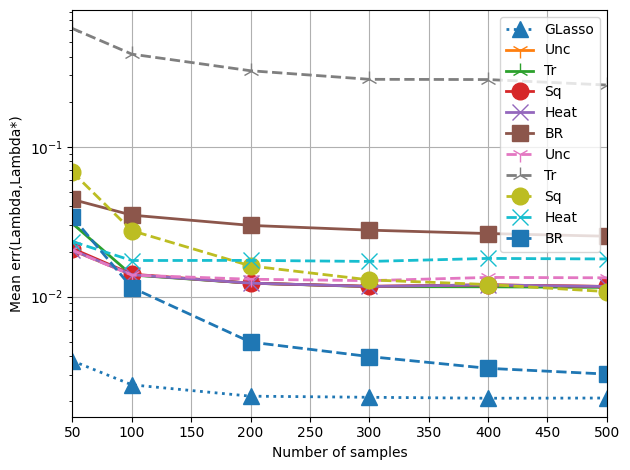

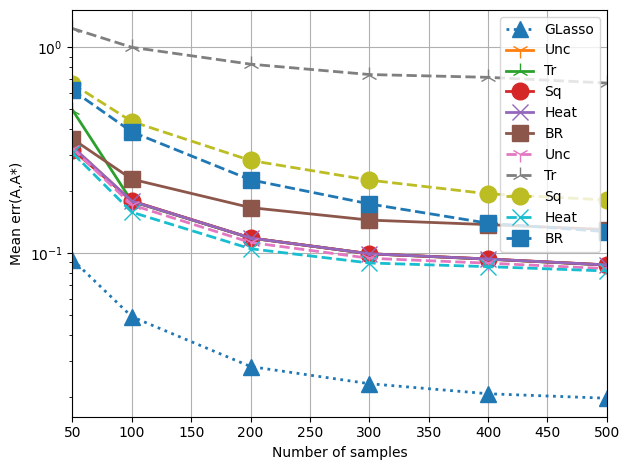

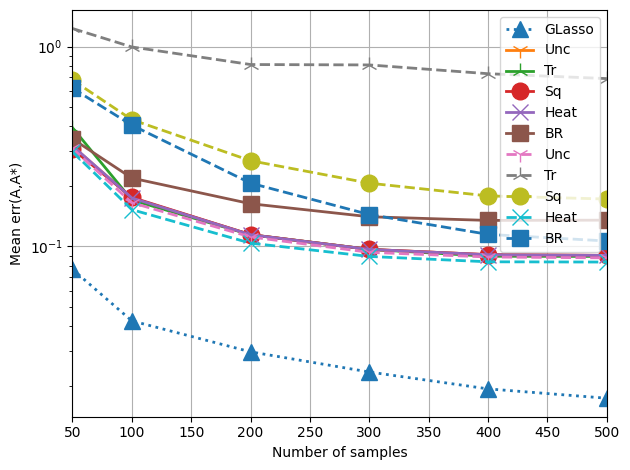

In [ ]:
err_A, err_lamd = est_errs(A, lambdas, As_hat, lamds_hat, sq_err=True)

mean_err_lam = np.mean(err_lamd, 2)
plot_err(MM, models, mean_err_lam, 'Mean err(Lambda,Lambda*)')
plt.savefig('tmp/err_lamb.png')

mean_err_A = np.mean(err_A, 2)
plot_err(MM, models, mean_err_A, 'Mean err(A,A*)')
plt.savefig('tmp/err_A.png')

mean_err_A = np.median(err_A, 2)
plot_err(MM, models, mean_err_A, 'Mean err(A,A*)')
plt.savefig('tmp/err_A.png')



In [ ]:
err_A, err_lamd = est_errs2(A, lambdas, As_hat, lamds_hat, sq_err=True)

mean_err_lam = np.mean(err_lamd, 2)
plot_err(MM, models, mean_err_lam, 'Mean err(Lambda,Lambda*)')
plt.savefig('tmp/err_lamb2.png')

mean_err_A = np.mean(err_A, 2)
plot_err(MM, models, mean_err_A, 'Mean err(A,A*)')
plt.savefig('tmp/err_A2.png')

mean_err_A = np.median(err_A, 2)
plot_err(MM, models, mean_err_A, 'Mean err(A,A*)')
plt.savefig('tmp/err_A_med2.png')

In [ ]:
# Save np data
# models_aux = [{'name': model['name'], 'fmt': model['fmt'], 'regs': model['regs']}
#                 for model in models]
# data = {
#     'A': A,
#     'lambdas': lambdas,
#     'lambdas0': lambdas0,
#     'As_hat': As_hat,
#     'lamds_hat': lamds_hat,
#     'MM': MM,
#     'models': models_aux
# }
# file = 'constraints_{}covs_{}iters'.format(n_covs, iters)
# np.save('results/constraints/' + file, data)

# # Save spectrum
# N = 200
# N0 = 150

# models_hist = [{'name': 'True spectrum'}] + models

# all_lambdas = np.concatenate((lambdas.reshape([N, 1]),
#                               np.squeeze(lamds_hat[:,:,idx,0])), axis=1)

# fname = PATH + 'constraints_hists.csv'
# utils.error_to_csv(fname, models_hist, [], all_lambdas)

# fname = PATH + 'constraints_hists_ref.csv'
# models_hist_ref = [{'name': 'Ref spectrum'}]
# utils.error_to_csv(fname, models_hist_ref, [], lambdas0.reshape([N0, 1]))

In [ ]:
# Save data as csv
# fname = PATH + 'constraints.csv'
# utils.error_to_csv(fname, models, MM, mean_err_lam)


In [ ]:
# %matplotlib qt

# # Load data
# file = 'results/constraints/constraints_100covs_200iters.npy'
# data = np.load(file, allow_pickle=True).item()
# models = data['models']

# A = data['A']
# lambdas = data['lambdas']
# lambdas0 = data['lambdas0']
# As_hat = data['As_hat']
# lamds_hat = data['lamds_hat']
# MM = data['MM']
# models = data['models']